#### 1) Imports and Random Seed

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import torchvision.models as models
import os
import random


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


#### 2) Dataset and Dataloader

In [3]:
class ImageRatingDataset(Dataset):
    
    def __init__(self, dataframe, transform=None, augment=False, phase=''):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.augment = augment
        self.phase=phase

        # Define augmentations
        self.augmentation = transforms.Compose([
            
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),  # small rotations
            transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes
        ])


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filename']
        rating = self.dataframe.loc[idx, 'MOS_ZScore']
        
        if self.phase == 'train':
            image = Image.open("../../dataset/images/train_images/" + img_path).convert('RGB')
        elif self.phase == 'test':
            image = Image.open("../../dataset/images/test_images/" + img_path).convert('RGB')
        
        if self.augment == True:
            image = self.augmentation(image)
            
        image_np = np.asarray(image, dtype=np.float32)
        image = torch.tensor(image_np)
        image = image.permute(2, 0, 1)
        
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rating, dtype=torch.float32)


#### 3) Create Model

In [4]:
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()

        # Load pretrained ResNet18
        base_model = models.resnet18(weights=True)

        # Remove the final classification layer
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Excludes fc layer

        # Freeze base layers
        for param in self.features.parameters():
            param.requires_grad = False

        # Add a custom regression head
        self.regressor = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)             # Output shape: (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)        # Flatten to (batch_size, 512)
        x = self.regressor(x)
        return x


#### 4) Training of model

In [5]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [6]:
def validate_model(model, val_loader):
    model.eval()
    val_predictions = []
    val_ground_truth = []

    with torch.no_grad():
        for images, ratings in val_loader:
            images = images.to(device)
            ratings = ratings.to(device)

            outputs = model(images).squeeze(1)  # Remove extra dimension

            val_predictions.extend(outputs.cpu().numpy())
            val_ground_truth.extend(ratings.cpu().numpy())

    # Compute SROCC
    srocc, _ = spearmanr(val_predictions, val_ground_truth)

    # Compute mean squared error for validation loss
    val_loss = mean_squared_error(val_ground_truth, val_predictions)

    return val_loss, srocc


In [7]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
model = ResNetRegressor().to(device)


/Users/annimukh/miniconda3/envs/image_realness/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.0001, λ=1):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()  # Mean squared error loss for regression
    train_losses = []
    val_losses = []
    srocc_scores = []
    
    # 1) init best‐model tracking
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for images, ratings in train_loader:
            images = images.to(device)
            ratings = ratings.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze(1)  # Remove extra dimension
            loss = mse_loss(outputs, ratings) 
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        val_loss, srocc = validate_model(model, val_loader)
        val_losses.append(val_loss)
        srocc_scores.append(srocc)
        

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss:.4f}, SROCC: {srocc:.4f}")
        
        
        # 2) save best on val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()
    
    # 3) load best weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f"Loaded best model from epoch with val_loss={best_val_loss:.4f}")
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    # plt.savefig('ResNet50_loss_plot.png')
    plt.show()
    
    return model, train_losses, val_losses, srocc_scores


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 230,145


#### 5) Load CSV and stratified split data, training loop

In [10]:
train_df = pd.read_csv("../../dataset/ratings/train.csv")
test_df = pd.read_csv("../../dataset/ratings/test.csv")

val_df = train_df.iloc[-90:].copy()
train_df = train_df.iloc[:-90].copy()

print(train_df.shape, val_df.shape, test_df.shape)


(420, 3) (90, 3) (90, 3)


Epoch [1/75], Loss: 1.0094, Validation Loss: 0.9810, SROCC: 0.2955
Epoch [2/75], Loss: 0.9436, Validation Loss: 0.9671, SROCC: 0.4536
Epoch [3/75], Loss: 1.1728, Validation Loss: 0.9495, SROCC: 0.4910
Epoch [4/75], Loss: 0.9061, Validation Loss: 0.9259, SROCC: 0.5472
Epoch [5/75], Loss: 0.9096, Validation Loss: 0.8978, SROCC: 0.5441
Epoch [6/75], Loss: 0.8969, Validation Loss: 0.8625, SROCC: 0.5448
Epoch [7/75], Loss: 0.8523, Validation Loss: 0.8201, SROCC: 0.5816
Epoch [8/75], Loss: 0.8551, Validation Loss: 0.7756, SROCC: 0.5755
Epoch [9/75], Loss: 0.8017, Validation Loss: 0.7332, SROCC: 0.5957
Epoch [10/75], Loss: 0.7447, Validation Loss: 0.7058, SROCC: 0.5676
Epoch [11/75], Loss: 0.7610, Validation Loss: 0.6605, SROCC: 0.5891
Epoch [12/75], Loss: 0.8662, Validation Loss: 0.6409, SROCC: 0.5958
Epoch [13/75], Loss: 0.7792, Validation Loss: 0.6257, SROCC: 0.6132
Epoch [14/75], Loss: 0.7241, Validation Loss: 0.6300, SROCC: 0.6082
Epoch [15/75], Loss: 0.6633, Validation Loss: 0.6185, SRO

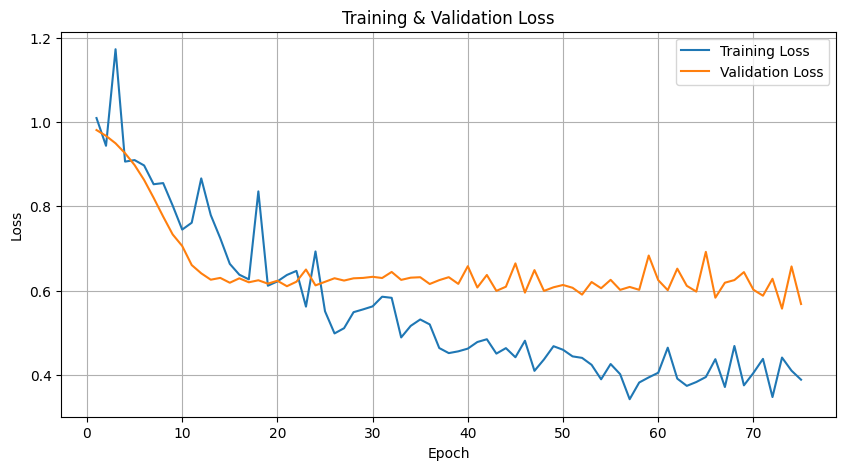

In [11]:
# Create dataset partitions
train_dataset = ImageRatingDataset(train_df, augment=True, phase='train')
val_dataset = ImageRatingDataset(val_df, phase='train')
test_dataset = ImageRatingDataset(test_df, phase='test')


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


# Start training
model, train_losses, val_losses, srocc_scores = train_model(model, train_loader, val_loader, num_epochs=75)


#### 6) Model Evaluation

In [12]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)
pearson_corr, _ = pearsonr(all_labels, all_preds)

print(spearman_corr, pearson_corr)


0.6684528954191875 0.73948795


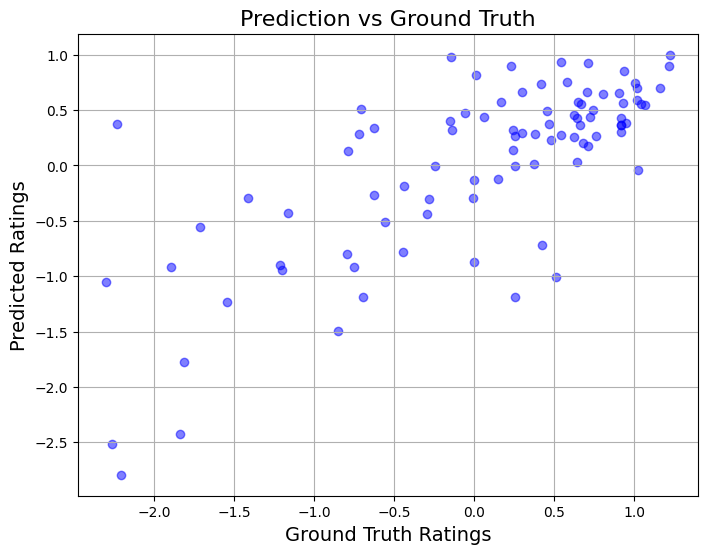

0.6684528954191875 0.73948795


In [13]:
predictions = []
ground_truths = []

# Iterate over the validation dataset
with torch.no_grad():
    for images, ratings in test_loader:
        images = images.to(device) 
        ratings = ratings.to(device)

        predicted_ratings = model(images)

        predictions.extend(predicted_ratings.cpu().numpy())
        ground_truths.extend(ratings.cpu().numpy())

predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()


plt.figure(figsize=(8, 6))
plt.scatter(ground_truths, predictions, alpha=0.5, c='blue')
plt.title('Prediction vs Ground Truth', fontsize=16)
plt.xlabel('Ground Truth Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid(True)
plt.show()

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(ground_truths, predictions)
pearson_corr, _ = pearsonr(ground_truths, predictions)

print(spearman_corr, pearson_corr)


In [14]:
import torch, os


SAVE_DIR = "./weights"          
WEIGHT_FILE = "resnet18_transf-learn-wts.pth"

os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(model.state_dict(), f"{SAVE_DIR}/{WEIGHT_FILE}")
print("✔️  Weights written to", f"{SAVE_DIR}/{WEIGHT_FILE}")


✔️  Weights written to ./weights/resnet18_transf-learn-wts.pth
